In [1]:
import pickle as pkl

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

pd.set_option('display.max_columns', 500)

%matplotlib inline

 #### Reading preprocessed data

In [2]:
course_details = pd.read_pickle('Preproccessed Data/course_details.pkl')

In [3]:
course_syllabi = pd.read_pickle('Preproccessed Data/course_syllabi.pkl')

In [4]:
course_reviews = pd.read_pickle('Preproccessed Data/course_reviews.pkl')

# Guidelines





 Can we predict success or is it random ?

- dont dive into topic, or content of the course, check predictivity for metadata first
- we can add how many other course treat the same topic ie topic popularity among dataset , for each course


### course content analysis

- Define how to measure success of a course ? ---> normlaize the total number of subs to each topic

- cluster the course topics: using the tags from  stack overflow we can have the popularity of a topic ? think about how to combine all the tags from a course to GET THE POPUARITY OF THE COURSE not the various popularities from 

- categorize the granularity of the courses : is it about webdev, or a specific tool in webdev ?

- Is it one of the first courses in this topic that are succesfull, or look like an existing one ?
- we can match the tags in the syllabus with tags from StacKoverflow


- is there a patern in appearance of courses in the same topic ? from the first course ever in this topic to the hole bundle of course, course in time analysis

### MetaData analysis :


- success measured by : (n subsriber)/(age)

- might try : dividing subscriber by log of age

- Maybe offset by course duration or length, for the same number of subscribers a 40h course is less succesfull than a 2 hour

- calculate a score for a set a successful courses, and say that sucessfulness is attainging 90% of this score.

- correlate the score value with feature of the course : how many lectures when published, how mayny were added

- check rating of the first month or 3 frst months

- HYPOTHESIS: the first moment a course is published is a major determinant of the success

- plot correlation of score and other ffeatures

### Objective : 
- **Set different ranks**
- **compare them then aggregate**
- **run regression**

For 21 November :

- (Clustering) the courses by topics (granulatrity, ...)
- for  each topic analyze  the feature of most and least succesfull courses.

cf paper

<img src="todo21Nov.jpg">

Here are the 3 features we discussed that are related to the topic of a course:
indicator variables for what the topic is
how many courses have come in its own topic before it
how popular are the courses in its own topic at the time of its publication

 (Ramtin 22 Novembre) 

### Difference in  means between paid and free courses :

- investigating the difference in success between paid and free course :


(only 384/9718, ~4% are free, we should have different criterions of success for paid and free courses )

In [5]:
course_details['is_paid'].value_counts()

True     9333
False     384
Name: is_paid, dtype: int64

We add histogram and boxplot to inspect for tail, maybe there is ONE course that has a lot more subscirbers than the group.

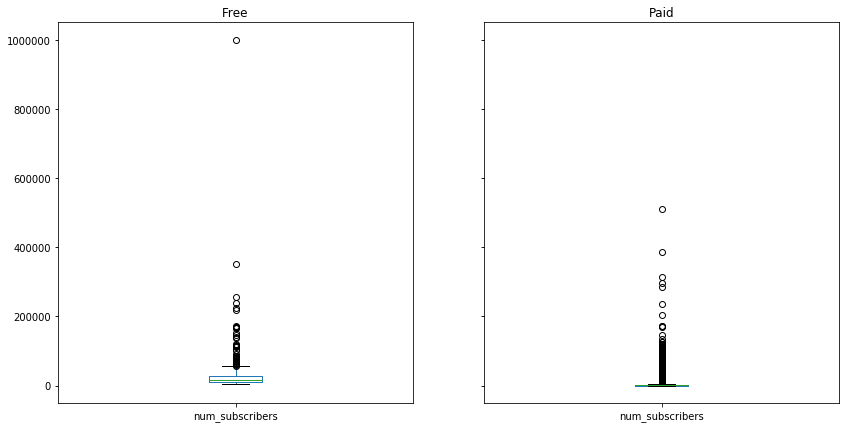

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,7))

# set title
ax[0].set_title('Free')
ax[1].set_title('Paid')


#plot

free = course_details[~course_details['is_paid']].sort_values('num_subscribers',ascending=False)
paid = course_details[ course_details['is_paid']].sort_values('num_subscribers',ascending=False)

free['num_subscribers'].plot.box(ax=ax[0])
paid['num_subscribers'].plot.box(ax=ax[1])

We observe that both distributions of number ofsubscribers for free and paid courses are very skewed. We drop one outlier from free and 2 ouliters from paid

In [7]:
#  outliers : one for free courses, 2 for paid courses
outliers_id = pd.concat([free.iloc[[0],:], paid.iloc[:2,:]]).index.tolist()

In [8]:
# we dont drop the outliers
#course_details.drop(outliers_id,inplace=True)

In [9]:
all_courses  = course_details.mean().rename('All courses')
paid_courses = course_details[course_details['is_paid']].mean().rename('Paid courses')
free_courses = course_details[~course_details['is_paid']].mean().rename('Free courses')

pd.concat([free_courses, paid_courses,all_courses], axis=1)

,Free courses,Paid courses,All courses
avg_rating,4.192206,3.658196,3.679299
avg_rating_recent,4.210535,3.656025,3.677938
is_paid,0.000000,1.000000,0.960482
num_published_lectures,30.984375,52.843459,51.979623
num_published_practice_tests,0.000000,0.012536,0.012041
num_published_quizzes,1.002604,1.242044,1.232582
num_reviews,1535.666667,305.072538,353.703612
num_reviews_recent,163.828125,46.936462,51.555830
num_subscribers,32066.526042,3584.828565,4710.378821
content_length,3.449826,6.269931,6.158485


First, we see the predominance of the paid courses as they represent 96% of this dataset. With this big proportion being paid, we can see the means of the paid group are very close to the means of the full dataset.

We observe that for success factors, free courses are dominating : in terms of total subrscibers, the free courses hit 9 times more subscriber and 5 times more reviews than the paid ones on average.

Conversely, free courses also seems to be less diligent in their content : the content length is doubled for paid courses, with 6h15 of lectures on averages for paid courses against 3h30 for free courses. The number of lectures is also higher for paid courses (+70%) .



In [10]:
# storing free courses before drop
course_details_free = course_details[~course_details['is_paid']]

In [11]:
# dropping free courses and is_paid column

course_details = course_details[course_details['is_paid']]
course_details.drop('is_paid', axis=1, inplace=True)

# ** Now we only work with paid courses **

##### CourseSyllabi

Let us plot the variety of content and its proportion in the dataset :  

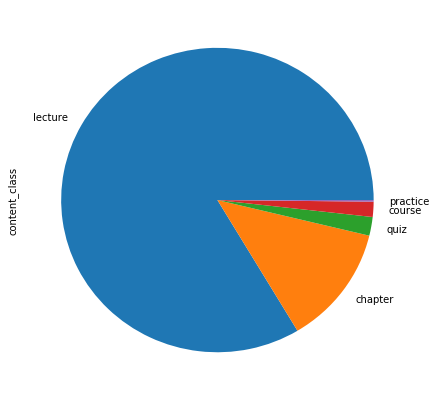

In [12]:
course_syllabi['content_class'].value_counts().plot.pie(y='content_class', figsize=(7,7))

### 1. Ranking the courses

In this section,  we try to rank the courses using meaningfull scales.

###### Rank1

In [13]:
# rank by ratings
course_details['Rank1 by avg_rating'] = course_details['avg_rating'].rank(method='min',ascending=False)

#### Rank2

In [14]:
# rank by num subscribers
course_details['Rank2 by num_subs'] = course_details['num_subscribers'].rank(method='min',ascending=False)

#### Rank 3 and 4

In [15]:
# Creating the column 'age in months'

# change today to when the dataset was scrapped : it was february 2019
course_details['age in days'] = (datetime(2019,2,28) - course_details['published_time']).apply(lambda x : ((x.days)/30)+1)

In [16]:
course_details['avg_r/(age)'] = course_details.apply(lambda row : row['avg_rating']/(row['age in days']), axis=1)

course_details['Rank3 by avg_r/(age)'] = course_details['avg_r/(age)'].rank(method='min', ascending=False)

In [17]:
course_details['n_subs/(age)'] = course_details.apply(lambda row : row['num_subscribers']/(row['age in days']), axis=1)

course_details['Rank4 by n_subs/(age)'] = course_details['n_subs/(age)'].rank(method='min',ascending=False)

#### Rank 5 and 6

In [18]:
c1 = 2 #0.0025
c2 = 5 #0.02

In [19]:
# rank by average rating divided by ln(course age in days)
course_details['avg_r/ln(age)'] = course_details.apply(lambda row : row['avg_rating']/np.log(c1*row['age in days']), axis=1)

In [20]:
course_details['Rank5 by avg_r/ln(age)'] = course_details['avg_r/ln(age)'].rank(method='min',ascending=False)

#course_details.drop('avg_r/ln(age)',axis=1,inplace=True)

course_details['n_subs/ln(age)'] = course_details.apply(lambda row : row['num_subscribers']/np.log(c2*row['age in days']), axis=1)

course_details['Rank6 by n_subs/ln(age)'] = course_details['n_subs/ln(age)'].rank(method='min',ascending=False)

#course_details.drop('n_subs/ln(age)',axis=1,inplace=True)


#### Comparing the ranks

**One first way to combine the 4 rankings, is to minimize the distance to all 4 ranks :  ==> By Mean of rankings**

We want our output rank to be such that each course rank is at minimal total distance of its input ranks, in this case they are 4, and to be a valid rank


In [21]:
course_details

,avg_rating,avg_rating_recent,created,last_update_date,num_published_lectures,num_published_practice_tests,num_published_quizzes,num_reviews,num_reviews_recent,num_subscribers,objectives,prerequisites,price,published_time,rating_distribution,target_audiences,title,url,content_length,publication_gap,Rank1 by avg_rating,Rank2 by num_subs,age in days,avg_r/(age),Rank3 by avg_r/(age),n_subs/(age),Rank4 by n_subs/(age),avg_r/ln(age),Rank5 by avg_r/ln(age),n_subs/ln(age),Rank6 by n_subs/ln(age)
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8082,4.38095,4.34115,2011-06-14 16:09:14,2015-10-15,56,0,5,620,18,28367,[Hours of video lectures detailing the ten ste...,[],$74.99,2011-07-08 21:32:55,"[{'count': 6, 'rating': 1}, {'count': 19, 'rat...",[],Ruby Programming for Beginners,/learn-ruby-programming-in-ten-easy-steps/,6.000000,0.066369,2554.0,203.0,94.033333,0.046589,8406.0,301.669621,1247.0,0.836571,7294.0,4610.206045,282.0
8203,3.45000,3.73183,2011-06-20 19:59:32,2017-07-10,15,0,1,12,10,1550,"[In this course, you will learn how to build a...",[PC or MAC with a browser installed],$99.99,2011-06-20 17:48:46,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[This course is intended for those who have ba...,Basic and Advanced HTML Lessons,/learn-html-in-24-hours/,1.000000,-0.000249,7245.0,3124.0,94.633333,0.036456,8464.0,16.379007,5274.0,0.658001,8186.0,251.645939,3597.0
8319,3.60000,3.79901,2011-06-28 04:48:38,NaT,31,0,0,12,10,290,"[The normal Git workflow, How to collaborate w...",[],$19.99,2011-07-29 20:24:56,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[],Git Basics: In Theory and Practice,/git-in-theory-and-in-practice/,7.500000,0.086713,6814.0,5516.0,93.333333,0.038571,8457.0,3.107143,7371.0,0.688425,8116.0,47.188115,5878.0
8324,3.95000,3.90651,2011-06-28 08:26:18,2018-07-06,48,0,6,243,10,3799,"[Extensive, informative and interesting video ...",[Some basic knowledge of HTML is required for ...,$19.99,2011-07-09 05:43:31,"[{'rating': 1, 'count': 8}, {'rating': 2, 'cou...",[Web Designers looking to improve their skill ...,Javascript for Beginners,/beginning-javascript/,3.000000,0.029827,5434.0,1719.0,94.000000,0.042021,8438.0,40.414894,4009.0,0.754329,7878.0,617.449219,2169.0
8325,4.65000,4.57516,2011-06-28 08:27:39,2018-07-06,82,0,5,284,10,12508,"[The HTML Document Structure For HTML 4.01, XH...","[PC, Mac or Linux PC, Text Editor (Free!), Web...",$19.99,2011-09-09 15:28:59,"[{'count': 5, 'rating': 1}, {'count': 8, 'rati...",[People who want to better manage their web si...,HTML Tutorial: HTML & CSS for Beginners,/learn-html5/,4.000000,0.200802,822.0,541.0,91.933333,0.050580,8348.0,136.055112,2212.0,0.891794,6651.0,2040.289823,775.0
8416,3.85000,3.98956,2011-07-05 19:40:19,2017-01-09,81,0,0,21,10,2039,[Everything you need to develop iOS apps for t...,[A system running Mac OSX is required to devel...,$49.99,2011-07-06 23:45:18,"[{'rating': 1, 'count': 4}, {'rating': 2, 'cou...",[Anyone who wants to learn how to build an iPh...,Beginners - How To Create iPhone And iPad Apps...,/beginners-guide-to-iphone-ipad-app-creation/,7.500000,0.003206,5893.0,2661.0,94.100000,0.040914,8446.0,21.668438,4905.0,0.735083,7951.0,331.340203,3110.0
8723,4.05000,4.15694,2011-07-25 05:16:32,2018-07-06,71,0,0,80,10,2018,[How to use Apples XCode Development Environme...,[],$19.99,2011-10-25 19:53:45,"[{'count': 4, 'rating': 1}, {'count': 3, 'rati...",[People without programming experience who wan...,C Programming: iOS Development Starts Here!,/c-programming-ios-development-starts-here/,4.000000,0.253724,4801.0,2684.0,90.400000,0.044801,8419.0,22.323009,4858.0,0.779237,7745.0,330.079311,3121.0
9463,4.22727,4.21872,2011-09-03 02:16:27,2017-01-09,114,0,0,1066,45,54180,[Learn Java Programming from a professional tr...,[],$49.99,2011-09-15 15:19:57,"[{'rating': 1, 'count': 34}, {'rating': 2, 'co...",[],Programming Java for Beginners - The Ultimate ...,/learn-to-program-with-java/,10.000000,0.034367,3695.0,85.0,91.733333,0.046082,8409.0,590.625000,687.0,0.811060,7509

In [22]:
agg_rank = (course_details['Rank3 by avg_r/(age)']+
             course_details['Rank5 by avg_r/ln(age)']+
             course_details['Rank1 by avg_rating']+
             course_details['Rank4 by n_subs/(age)']+
             course_details['Rank6 by n_subs/ln(age)']+
             course_details['Rank2 by num_subs'])/6

course_details['Rank aggreg']= agg_rank.rank(method='min',ascending=True)

Correlation:

In [23]:
ranks_Df = course_details[['Rank3 by avg_r/(age)',
                           'Rank4 by n_subs/(age)',
                           'Rank1 by avg_rating',
                           'Rank2 by num_subs',
                           'Rank5 by avg_r/ln(age)',
                           'Rank6 by n_subs/ln(age)',
                           'Rank aggreg']]
corr = ranks_Df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,Rank3 by avg_r/(age),Rank4 by n_subs/(age),Rank1 by avg_rating,Rank2 by num_subs,Rank5 by avg_r/ln(age),Rank6 by n_subs/ln(age),Rank aggreg
Rank3 by avg_r/(age),1,0.330092,0.472715,0.0791468,0.937804,0.137937,0.619897
Rank4 by n_subs/(age),0.330092,1,0.348233,0.937995,0.382194,0.963173,0.883665
Rank1 by avg_rating,0.472715,0.348233,1,0.316874,0.697052,0.326466,0.666868
Rank2 by num_subs,0.0791468,0.937995,0.316874,1,0.166505,0.996393,0.76315
Rank5 by avg_r/ln(age),0.937804,0.382194,0.697052,0.166505,1,0.218403,0.723729
Rank6 by n_subs/ln(age),0.137937,0.963173,0.326466,0.996393,0.218403,1,0.799338
Rank aggreg,0.619897,0.883665,0.666868,0.76315,0.723729,0.799338,1


**==>**  Finally, we will only keep the Rank4 (**n_subs/age**), as it is the most correlated one with the aggregated rank.

In [24]:
course_details.drop(['Rank1 by avg_rating',
                     'Rank2 by num_subs',
                     'avg_r/(age)',
                     'Rank3 by avg_r/(age)',
                     'avg_r/ln(age)',
                     'Rank5 by avg_r/ln(age)',
                     'n_subs/ln(age)',
                     'Rank6 by n_subs/ln(age)'], axis=1, inplace=True)

In [25]:
course_details

,avg_rating,avg_rating_recent,created,last_update_date,num_published_lectures,num_published_practice_tests,num_published_quizzes,num_reviews,num_reviews_recent,num_subscribers,objectives,prerequisites,price,published_time,rating_distribution,target_audiences,title,url,content_length,publication_gap,age in days,n_subs/(age),Rank4 by n_subs/(age),Rank aggreg
id,,,,,,,,,,,,,,,,,,,,,,,,
8082,4.38095,4.34115,2011-06-14 16:09:14,2015-10-15,56,0,5,620,18,28367,[Hours of video lectures detailing the ten ste...,[],$74.99,2011-07-08 21:32:55,"[{'count': 6, 'rating': 1}, {'count': 19, 'rat...",[],Ruby Programming for Beginners,/learn-ruby-programming-in-ten-easy-steps/,6.000000,0.066369,94.033333,301.669621,1247.0,2657.0
8203,3.45000,3.73183,2011-06-20 19:59:32,2017-07-10,15,0,1,12,10,1550,"[In this course, you will learn how to build a...",[PC or MAC with a browser installed],$99.99,2011-06-20 17:48:46,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[This course is intended for those who have ba...,Basic and Advanced HTML Lessons,/learn-html-in-24-hours/,1.000000,-0.000249,94.633333,16.379007,5274.0,7068.0
8319,3.60000,3.79901,2011-06-28 04:48:38,NaT,31,0,0,12,10,290,"[The normal Git workflow, How to collaborate w...",[],$19.99,2011-07-29 20:24:56,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[],Git Basics: In Theory and Practice,/git-in-theory-and-in-practice/,7.500000,0.086713,93.333333,3.107143,7371.0,8060.0
8324,3.95000,3.90651,2011-06-28 08:26:18,2018-07-06,48,0,6,243,10,3799,"[Extensive, informative and interesting video ...",[Some basic knowledge of HTML is required for ...,$19.99,2011-07-09 05:43:31,"[{'rating': 1, 'count': 8}, {'rating': 2, 'cou...",[Web Designers looking to improve their skill ...,Javascript for Beginners,/beginning-javascript/,3.000000,0.029827,94.000000,40.414894,4009.0,5551.0
8325,4.65000,4.57516,2011-06-28 08:27:39,2018-07-06,82,0,5,284,10,12508,"[The HTML Document Structure For HTML 4.01, XH...","[PC, Mac or Linux PC, Text Editor (Free!), Web...",$19.99,2011-09-09 15:28:59,"[{'count': 5, 'rating': 1}, {'count': 8, 'rati...",[People who want to better manage their web si...,HTML Tutorial: HTML & CSS for Beginners,/learn-html5/,4.000000,0.200802,91.933333,136.055112,2212.0,2483.0
8416,3.85000,3.98956,2011-07-05 19:40:19,2017-01-09,81,0,0,21,10,2039,[Everything you need to develop iOS apps for t...,[A system running Mac OSX is required to devel...,$49.99,2011-07-06 23:45:18,"[{'rating': 1, 'count': 4}, {'rating': 2, 'cou...",[Anyone who wants to learn how to build an iPh...,Beginners - How To Create iPhone And iPad Apps...,/beginners-guide-to-iphone-ipad-app-creation/,7.500000,0.003206,94.100000,21.668438,4905.0,6398.0
8723,4.05000,4.15694,2011-07-25 05:16:32,2018-07-06,71,0,0,80,10,2018,[How to use Apples XCode Development Environme...,[],$19.99,2011-10-25 19:53:45,"[{'count': 4, 'rating': 1}, {'count': 3, 'rati...",[People without programming experience who wan...,C Programming: iOS Development Starts Here!,/c-programming-ios-development-starts-here/,4.000000,0.253724,90.400000,22.323009,4858.0,6059.0
9463,4.22727,4.21872,2011-09-03 02:16:27,2017-01-09,114,0,0,1066,45,54180,[Learn Java Programming from a professional tr...,[],$49.99,2011-09-15 15:19:57,"[{'rating': 1, 'count': 34}, {'rating': 2, 'co...",[],Programming Java for Beginners - The Ultimate ...,/learn-to-program-with-java/,10.000000,0.034367,91.733333,590.625000,687.0,2811.0
10321,4.52273,4.55383,2011-10-13 02:42:33,2017-01-09,108,0,0,434,19,3908,[How to create a functional app from start to ...,[],$49.99,2011-10-14 21:48:38,"[{'count': 5, 'rating': 1}, {'count': 5, 'rati...",[Anyone with an interest in creating their own...,Learn to Program with C++,/learn-c/,10.000000,0.004920,90.766667,43.055454,3908.0,3931.0


We now plot the distribution of **n_subs/age** over the dataset.

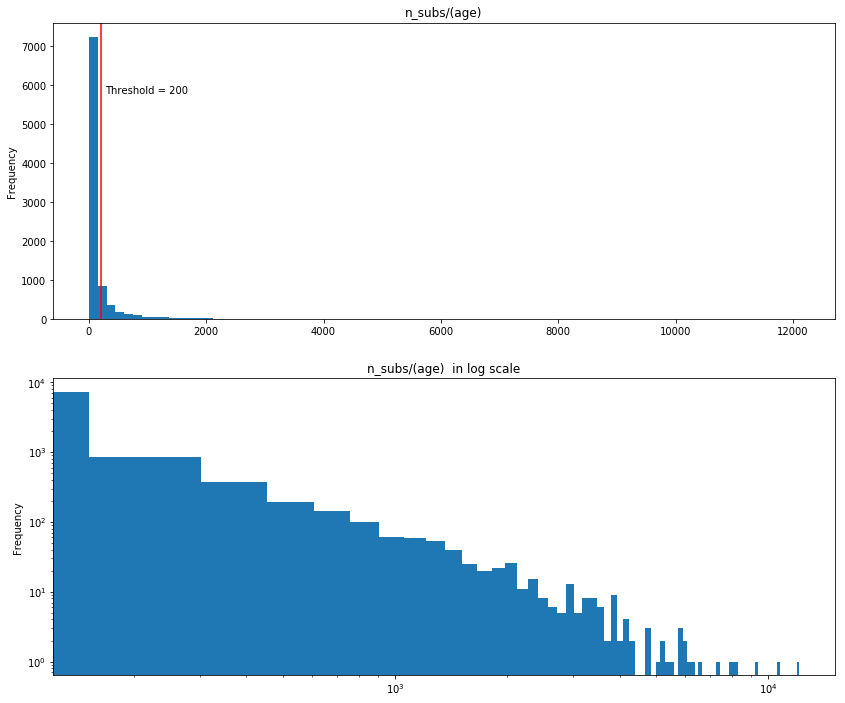

In [26]:
fig, ax= plt.subplots(2,1,figsize=(14,12))

course_details['n_subs/(age)'].sort_values().plot.hist(bins=80, title='n_subs/(age)',ax=ax[0])
ax[0].axvline(200, color='r')
ax[0].text(0.12, 0.77, 'Threshold = 200', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

course_details['n_subs/(age)'].sort_values().plot.hist(bins=80, title='n_subs/(age)  in log scale',ax=ax[1])

plt.yscale('log')
plt.xscale('log')

In [27]:
# models to predict succesfulness, then we do the harmonic mean of accuray and prctge of data used, then pick best

In [28]:
ser = course_details['n_subs/(age)'].apply(lambda x : x>200) # how to choose this threshold
ser.mean()

0.18450658952105434

We have 18.5% of the courses that score higher than 200 at this metric ( **n_subs/(age)** ). 
We **label them as successfull** and we now have our **dependant variable**

In [29]:
course_details['success'] = ser

**What are the biggest courses in term of number of elements ?** here we consider an element any content present in course_syllabi and affiliated to a course via course_id column.

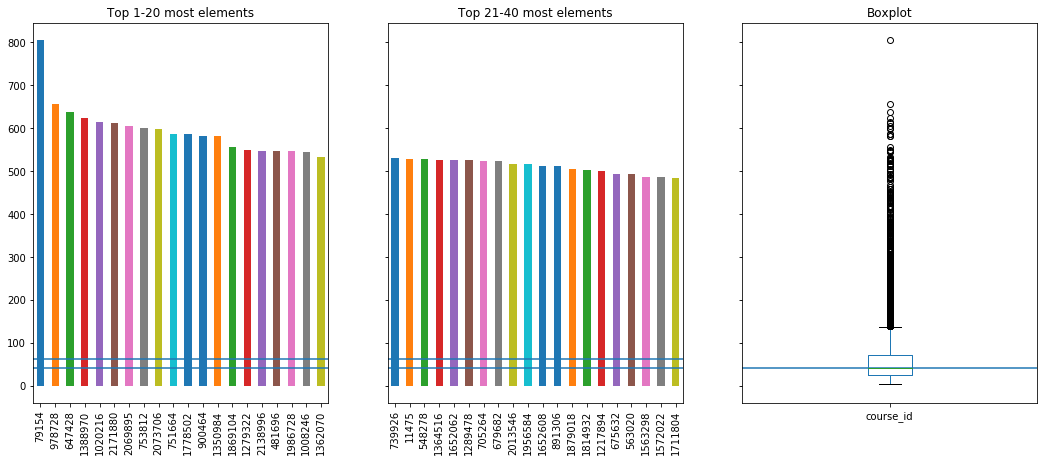

In [30]:
fig, ax = plt.subplots(1,3, sharey=True)

course_syllabi['course_id'].value_counts().head(20).plot(ax=ax[0], kind='bar', figsize=(18,7))

ax[0].axhline(course_syllabi['course_id'].value_counts().mean())
ax[0].axhline(course_syllabi['course_id'].value_counts().median())
ax[0].set_title('Top 1-20 most elements')

course_syllabi['course_id'].value_counts().head(40).tail(20).tail(20).plot(ax=ax[1], kind='bar', figsize=(18,7))

ax[1].axhline(course_syllabi['course_id'].value_counts().mean())
ax[1].axhline(course_syllabi['course_id'].value_counts().median())
ax[1].set_title('Top 21-40 most elements')

course_syllabi['course_id'].value_counts().plot.box(ax=ax[2])
ax[2].set_title('Boxplot')
ax[2].axhline(course_syllabi['course_id'].value_counts().median())

We can see there is a large gap between the top representives and the rest.

In [31]:
course_details['nbr of course element'] = course_syllabi['course_id'].value_counts()

### **How are courses updated?** Each course has a dataframe of various updates, we are gonna investigate it here 

In [32]:
course_syllabi

,course_id,chapter_title,chapter_description,chapter_created,content_class,title,description,created_content,is_published,content_summary,url,created_course,published_time,age_from_creation,age_from_publication
0,8082,NaN,NaN,NaT,course,Ruby Programming for Beginners,NaN,2011-06-14 16:09:14,NaN,NaN,/learn-ruby-programming-in-ten-easy-steps/,2011-06-14 16:09:14,2011-07-08 21:32:55,0.000000,-0.066369
1,8082,NaN,NaN,NaT,chapter,Introduction,NaN,2011-06-17 21:36:49,True,NaN,NaN,2011-06-14 16:09:14,2011-07-08 21:32:55,0.008842,-0.057527
2,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Ruby Programming for Beginners - Intro,NaN,2012-02-17 17:57:19,True,01:55,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.679658,0.613288
3,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Welcome To Ruby Programming In Ten Easy Steps,"<p style=""""> \t Welcome to the course! This is...",2014-04-18 17:44:49,True,07:40,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,2.846757,2.780388
4,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,The Little Book Of Ruby,"<p> \t<strong style="""">The Little Book Of Ruby...",2015-07-12 11:13:02,True,101 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,4.078889,4.012519
5,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Little Book Of Ruby Code Archive,<p>This code archive contains all the programs...,2011-07-06 15:26:52,True,27.3 kB,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.060193,-0.006176
6,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Started FAQ And Resources,This document lists essential online resources...,2011-07-26 16:10:57,True,9 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.115072,0.048702
7,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Exclusive Discount on The (Big) Book Of Ruby,Subscribers to this course are entitled to a 3...,2011-07-12 00:42:40,True,01:14,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.074949,0.008580
8,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Ready,"<p style="""">First install a Ruby interpreter a...",2011-06-15 18:01:06,True,04:27,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.002953,-0.063417
9,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,First Steps on a Mac,"<p>If you are a Mac user, this video will guid...",2011-09-26 22:11:50,True,04:03,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.285621,0.219252


In [33]:
time_serie = course_syllabi[['course_id','published_time']].groupby('course_id')['published_time'].apply(list)

In [34]:
a = time_serie.index.tolist()
b = course_details.index.tolist()

# some courses in syllabi are not in details : might be free courses
not_in_details = (set(a)-set(b))

In [35]:
free = set(course_details_free.index.tolist())

In [36]:
# all free courses are in the missing set
free-not_in_details

set()

In [37]:
# this last course was removed during preprocessing as an outlier
not_in_details -free  

{1965490}

**Average update delay**

In [38]:
# function to be used in calculating time interval between consecutive updates

def diff(lst):
    # should handle empty and one elem lists

    res =[] 
    for i in range(len(lst)-1):
        res.append(lst[i+1]-lst[i])
    
    if res == []: res = [timedelta(0)]
    return res

In [39]:
course_details['update_date_list'] = time_serie.apply(lambda x : sorted(x) )
course_details['update_delta_list'] = course_details['update_date_list'].apply(diff)
course_details['Avg update delay'] = course_details['update_delta_list'].apply(lambda x : sum(x,timedelta(0)) / len(x) )

course_details['Avg update delay (days)'] = course_details['Avg update delay'].apply(lambda x : x.total_seconds()/(60*60*24))

In [40]:
course_details

,avg_rating,avg_rating_recent,created,last_update_date,num_published_lectures,num_published_practice_tests,num_published_quizzes,num_reviews,num_reviews_recent,num_subscribers,objectives,prerequisites,price,published_time,rating_distribution,target_audiences,title,url,content_length,publication_gap,age in days,n_subs/(age),Rank4 by n_subs/(age),Rank aggreg,success,nbr of course element,update_date_list,update_delta_list,Avg update delay,Avg update delay (days)
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8082,4.38095,4.34115,2011-06-14 16:09:14,2015-10-15,56,0,5,620,18,28367,[Hours of video lectures detailing the ten ste...,[],$74.99,2011-07-08 21:32:55,"[{'count': 6, 'rating': 1}, {'count': 19, 'rat...",[],Ruby Programming for Beginners,/learn-ruby-programming-in-ten-easy-steps/,6.000000,0.066369,94.033333,301.669621,1247.0,2657.0,True,75,"[2011-07-08 21:32:55, 2011-07-08 21:32:55, 201...","[0 days 00:00:00, 0 days 00:00:00, 0 days 00:0...",0 days,0.0
8203,3.45000,3.73183,2011-06-20 19:59:32,2017-07-10,15,0,1,12,10,1550,"[In this course, you will learn how to build a...",[PC or MAC with a browser installed],$99.99,2011-06-20 17:48:46,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[This course is intended for those who have ba...,Basic and Advanced HTML Lessons,/learn-html-in-24-hours/,1.000000,-0.000249,94.633333,16.379007,5274.0,7068.0,False,20,"[2011-06-20 17:48:46, 2011-06-20 17:48:46, 201...","[0 days 00:00:00, 0 days 00:00:00, 0 days 00:0...",0 days,0.0
8319,3.60000,3.79901,2011-06-28 04:48:38,NaT,31,0,0,12,10,290,"[The normal Git workflow, How to collaborate w...",[],$19.99,2011-07-29 20:24:56,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[],Git Basics: In Theory and Practice,/git-in-theory-and-in-practice/,7.500000,0.086713,93.333333,3.107143,7371.0,8060.0,False,36,"[2011-07-29 20:24:56, 2011-07-29 20:24:56, 201...","[0 days 00:00:00, 0 days 00:00:00, 0 days 00:0...",0 days,0.0
8324,3.95000,3.90651,2011-06-28 08:26:18,2018-07-06,48,0,6,243,10,3799,"[Extensive, informative and interesting video ...",[Some basic knowledge of HTML is required for ...,$19.99,2011-07-09 05:43:31,"[{'rating': 1, 'count': 8}, {'rating': 2, 'cou...",[Web Designers looking to improve their skill ...,Javascript for Beginners,/beginning-javascript/,3.000000,0.029827,94.000000,40.414894,4009.0,5551.0,False,67,"[2011-07-09 05:43:31, 2011-07-09 05:43:31, 201...","[0 days 00:00:00, 0 days 00:00:00, 0 days 00:0...",0 days,0.0
8325,4.65000,4.57516,2011-06-28 08:27:39,2018-07-06,82,0,5,284,10,12508,"[The HTML Document Structure For HTML 4.01, XH...","[PC, Mac or Linux PC, Text Editor (Free!), Web...",$19.99,2011-09-09 15:28:59,"[{'count': 5, 'rating': 1}, {'count': 8, 'rati...",[People who want to better manage their web si...,HTML Tutorial: HTML & CSS for Beginners,/learn-html5/,4.000000,0.200802,91.933333,136.055112,2212.0,2483.0,False,99,"[2011-09-09 15:28:59, 2011-09-09 15:28:59, 201...","[0 days 00:00:00, 0 days 00:00:00, 0 days 00:0...",0 days,0.0
8416,3.85000,3.98956,2011-07-05 19:40:19,2017-01-09,81,0,0,21,10,2039,[Everything you need to develop iOS apps for t...,[A system running Mac OSX is required to devel...,$49.99,2011-07-06 23:45:18,"[{'rating': 1, 'count': 4}, {'rating': 2, 'cou...",[Anyone who wants to learn how to build an iPh...,Beginners - How To Create iPhone And iPad Apps...,/beginners-guide-to-iphone-ipad-app-creation/,7.500000,0.003206,94.100000,21.668438,4905.0,6398.0,False,96,"[2011-07-06 23:45:18, 2011-07-06 23:45:18, 201...","[0 days 00:00:00, 0 days 00:00:00, 0 days 00:0...",0 days,0.0
8723,4.05000,4.15694,2011-07-25 05:16:32,2018-07-06,71,0,0,80,10,2018,[How to use Apples XCode Development Environme...,[],$19.99,2011-10-25 19:53:45,"[{'count': 4, 'rating': 1}, {'count': 3, 'rati...",[People without programming experience who wan...,C Programming: iOS Development Starts Here!,/c-programming-ios-development-starts-here/,4.000000,0.253724,90.400000,22.323009,4858.0,6059.0,False,83,"[2011-10-25 19:53:45, 2011-10-25 19:53:45, 201.

In [41]:
course_syllabi

,course_id,chapter_title,chapter_description,chapter_created,content_class,title,description,created_content,is_published,content_summary,url,created_course,published_time,age_from_creation,age_from_publication
0,8082,NaN,NaN,NaT,course,Ruby Programming for Beginners,NaN,2011-06-14 16:09:14,NaN,NaN,/learn-ruby-programming-in-ten-easy-steps/,2011-06-14 16:09:14,2011-07-08 21:32:55,0.000000,-0.066369
1,8082,NaN,NaN,NaT,chapter,Introduction,NaN,2011-06-17 21:36:49,True,NaN,NaN,2011-06-14 16:09:14,2011-07-08 21:32:55,0.008842,-0.057527
2,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Ruby Programming for Beginners - Intro,NaN,2012-02-17 17:57:19,True,01:55,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.679658,0.613288
3,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Welcome To Ruby Programming In Ten Easy Steps,"<p style=""""> \t Welcome to the course! This is...",2014-04-18 17:44:49,True,07:40,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,2.846757,2.780388
4,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,The Little Book Of Ruby,"<p> \t<strong style="""">The Little Book Of Ruby...",2015-07-12 11:13:02,True,101 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,4.078889,4.012519
5,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Little Book Of Ruby Code Archive,<p>This code archive contains all the programs...,2011-07-06 15:26:52,True,27.3 kB,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.060193,-0.006176
6,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Started FAQ And Resources,This document lists essential online resources...,2011-07-26 16:10:57,True,9 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.115072,0.048702
7,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Exclusive Discount on The (Big) Book Of Ruby,Subscribers to this course are entitled to a 3...,2011-07-12 00:42:40,True,01:14,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.074949,0.008580
8,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Ready,"<p style="""">First install a Ruby interpreter a...",2011-06-15 18:01:06,True,04:27,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.002953,-0.063417
9,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,First Steps on a Mac,"<p>If you are a Mac user, this video will guid...",2011-09-26 22:11:50,True,04:03,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.285621,0.219252


**Type of updated content**

In [42]:
course_syllabi['content_summary'] = course_syllabi['content_summary'].fillna('')

course_syllabi['content is in pages'] = course_syllabi['content_summary'].apply(lambda x : 'page' in x)
course_syllabi['content is in time'] = course_syllabi['content_summary'].apply(lambda x : ':' in x)
course_syllabi['content is in bytes'] = course_syllabi['content_summary'].apply(lambda x : 'B' in x)
course_syllabi['content is na'] = course_syllabi['content_summary'].apply(lambda x : x=='')

course_syllabi['at least one'] = course_syllabi['content is in pages'] |course_syllabi['content is in time']|course_syllabi['content is in bytes']|course_syllabi['content is na']
course_syllabi['exactly one'] = course_syllabi['content is in pages'] ^ course_syllabi['content is in time']^course_syllabi['content is in bytes']^course_syllabi['content is na']

In [43]:
course_syllabi[course_syllabi['at least one']==False]['content_summary'].value_counts()

Processing..    194
IFrame            3
Name: content_summary, dtype: int64

In [44]:
course_syllabi[course_syllabi['exactly one']==False]['content_summary'].value_counts()

Processing..    194
IFrame            3
Name: content_summary, dtype: int64

** What are processing and IFrame** all our data points are from exactly one of the three types of content, but 2 more content_type are unknown : 'Processing' and 'IFrame', these content will not be counted as some size of updates.  **==> We turn these  values to nan.
**

In [45]:
# We treat them as nans
course_syllabi['content_summary'].fillna('Processing..', inplace=True)
course_syllabi['content_summary'].fillna('IFrame', inplace=True)

**Average size of update**

We have 3 types of content : Number of pages, time, and filesize (in Bytes).

In [46]:
# do operation for each in syllabi, then sum in details
course_syllabi['size_in_pages']= course_syllabi[course_syllabi['content is in pages']]['content_summary'].\
                                    apply(lambda st : sum([int(s) for s in st.split() if s.isdigit() ]))


course_details['size_in_pages'] = course_syllabi[course_syllabi['content is in pages']][['course_id','size_in_pages']].\
                                    groupby('course_id')['size_in_pages'].\
                                    apply(sum)

In [47]:
course_syllabi

,course_id,chapter_title,chapter_description,chapter_created,content_class,title,description,created_content,is_published,content_summary,url,created_course,published_time,age_from_creation,age_from_publication,content is in pages,content is in time,content is in bytes,content is na,at least one,exactly one,size_in_pages
0,8082,NaN,NaN,NaT,course,Ruby Programming for Beginners,NaN,2011-06-14 16:09:14,NaN,,/learn-ruby-programming-in-ten-easy-steps/,2011-06-14 16:09:14,2011-07-08 21:32:55,0.000000,-0.066369,False,False,False,True,True,True,NaN
1,8082,NaN,NaN,NaT,chapter,Introduction,NaN,2011-06-17 21:36:49,True,,NaN,2011-06-14 16:09:14,2011-07-08 21:32:55,0.008842,-0.057527,False,False,False,True,True,True,NaN
2,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Ruby Programming for Beginners - Intro,NaN,2012-02-17 17:57:19,True,01:55,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.679658,0.613288,False,True,False,False,True,True,NaN
3,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Welcome To Ruby Programming In Ten Easy Steps,"<p style=""""> \t Welcome to the course! This is...",2014-04-18 17:44:49,True,07:40,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,2.846757,2.780388,False,True,False,False,True,True,NaN
4,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,The Little Book Of Ruby,"<p> \t<strong style="""">The Little Book Of Ruby...",2015-07-12 11:13:02,True,101 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,4.078889,4.012519,True,False,False,False,True,True,101.0
5,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Little Book Of Ruby Code Archive,<p>This code archive contains all the programs...,2011-07-06 15:26:52,True,27.3 kB,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.060193,-0.006176,False,False,True,False,True,True,NaN
6,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Started FAQ And Resources,This document lists essential online resources...,2011-07-26 16:10:57,True,9 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.115072,0.048702,True,False,False,False,True,True,9.0
7,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Exclusive Discount on The (Big) Book Of Ruby,Subscribers to this course are entitled to a 3...,2011-07-12 00:42:40,True,01:14,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.074949,0.008580,False,True,False,False,True,True,NaN
8,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Ready,"<p style="""">First install a Ruby interpreter a...",2011-06-15 18:01:06,True,04:27,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.002953,-0.063417,False,True,False,False,True,True,NaN
9,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,First Steps on a Mac,"<p>If you are a Mac user, this video will guid...",2011-09-26 22:11:50,True,04:03,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.285621,0.219252,False,True,False,False,True,True,NaN


In [48]:
course_syllabi['size_in_seconds'] = course_syllabi[course_syllabi['content is in time']]['content_summary'].\
                                    apply(lambda elem :  [int(i) for i in elem.split(':')]).\
                                    apply(lambda x : x[0]*60+x[1])

course_details['size_in_seconds'] = course_syllabi[course_syllabi['content is in time']][['course_id','size_in_seconds']].\
                                    groupby('course_id')['size_in_seconds'].\
                                    apply(sum)

In [49]:
course_syllabi['size_in_bytes'] = course_syllabi[course_syllabi['content is in bytes']]['content_summary'].\
                                    apply(lambda elem :  elem.split(' ')).\
                                    apply(lambda couple : float(couple[0]) if couple[1] =='Bytes' else \
                                                      (float(couple[0])*10**3 if couple[1]=='kB' else\
                                                       (float(couple[0])*10**6 if couple[1]=='MB' else\
                                                        couple)))

course_details['size_in_bytes'] = course_syllabi[course_syllabi['content is in bytes']][['course_id','size_in_bytes']].\
                                    groupby('course_id')['size_in_bytes'].\
                                    apply(sum)

**NA count**

In [50]:
course_details[['size_in_pages','size_in_bytes', 'size_in_seconds']].isna().sum()

size_in_pages      8762
size_in_bytes      9292
size_in_seconds       0
dtype: int64

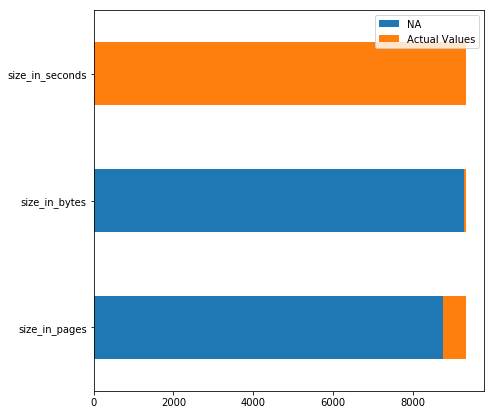

In [51]:
df = pd.concat([course_details[['size_in_pages','size_in_bytes', 'size_in_seconds']].isna().sum(), course_details.shape[0]-course_details[['size_in_pages','size_in_bytes', 'size_in_seconds']].isna().sum()], axis=1)
df.rename(columns={0:'NA', 1:'Actual Values'},inplace=True)
df.plot.barh(stacked=True, figsize=(7,7))

As size in bytes and in pages is not present for a significant portion of the dataset, we will only consider size in seconds.

** need to take into account the fact that there is a 'bulk loading' of  course items when it is created
**

In [52]:
# add a column 'TimeSinceLastUpdate', and divide each of the quantities by,this time,
# if its the first post then it will be Nan, so we dont count it in the average

#course_syllabi['isCourse'] = course_syllabi['content_class'].apply(lambda x : x !='course')

# order course component by date for each course 
course_syllabi.sort_values(['course_id','published_time'],inplace=True)
course_syllabi.reset_index(drop=True,inplace=True)

course_syllabi['TimeSinceLastUpdate'] = course_syllabi.published_time - course_syllabi.published_time.shift(1)

# since we ordered, we need to clear the line of every first course apprearance
course_syllabi.loc[course_syllabi['content_class']=='course','TimeSinceLastUpdate'] = np.nan


course_syllabi['TimeSinceLastUpdate(days)'] = course_syllabi['TimeSinceLastUpdate'].apply(lambda x : x.total_seconds()/(60*60*24))

course_syllabi['updateSize/TimeSinceLastUpdate'] = course_syllabi['size_in_seconds']/course_syllabi['TimeSinceLastUpdate(days)']
course_syllabi


,course_id,chapter_title,chapter_description,chapter_created,content_class,title,description,created_content,is_published,content_summary,url,created_course,published_time,age_from_creation,age_from_publication,content is in pages,content is in time,content is in bytes,content is na,at least one,exactly one,size_in_pages,size_in_seconds,size_in_bytes,TimeSinceLastUpdate,TimeSinceLastUpdate(days),updateSize/TimeSinceLastUpdate
0,8082,NaN,NaN,NaT,course,Ruby Programming for Beginners,NaN,2011-06-14 16:09:14,NaN,,/learn-ruby-programming-in-ten-easy-steps/,2011-06-14 16:09:14,2011-07-08 21:32:55,0.000000,-0.066369,False,False,False,True,True,True,NaN,NaN,NaN,NaT,NaN,NaN
1,8082,NaN,NaN,NaT,chapter,Introduction,NaN,2011-06-17 21:36:49,True,,NaN,2011-06-14 16:09:14,2011-07-08 21:32:55,0.008842,-0.057527,False,False,False,True,True,True,NaN,NaN,NaN,0 days,0.0,NaN
2,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Ruby Programming for Beginners - Intro,NaN,2012-02-17 17:57:19,True,01:55,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.679658,0.613288,False,True,False,False,True,True,NaN,115.0,NaN,0 days,0.0,inf
3,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Welcome To Ruby Programming In Ten Easy Steps,"<p style=""""> \t Welcome to the course! This is...",2014-04-18 17:44:49,True,07:40,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,2.846757,2.780388,False,True,False,False,True,True,NaN,460.0,NaN,0 days,0.0,inf
4,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,The Little Book Of Ruby,"<p> \t<strong style="""">The Little Book Of Ruby...",2015-07-12 11:13:02,True,101 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,4.078889,4.012519,True,False,False,False,True,True,101.0,NaN,NaN,0 days,0.0,NaN
5,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Little Book Of Ruby Code Archive,<p>This code archive contains all the programs...,2011-07-06 15:26:52,True,27.3 kB,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.060193,-0.006176,False,False,True,False,True,True,NaN,NaN,27300.0,0 days,0.0,NaN
6,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Started FAQ And Resources,This document lists essential online resources...,2011-07-26 16:10:57,True,9 pages,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.115072,0.048702,True,False,False,False,True,True,9.0,NaN,NaN,0 days,0.0,NaN
7,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Exclusive Discount on The (Big) Book Of Ruby,Subscribers to this course are entitled to a 3...,2011-07-12 00:42:40,True,01:14,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.074949,0.008580,False,True,False,False,True,True,NaN,74.0,NaN,0 days,0.0,inf
8,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Getting Ready,"<p style="""">First install a Ruby interpreter a...",2011-06-15 18:01:06,True,04:27,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.002953,-0.063417,False,True,False,False,True,True,NaN,267.0,NaN,0 days,0.0,inf
9,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,First Steps on a Mac,"<p>If you are a Mac user, this video will guid...",2011-09-26 22:11:50,True,04:03,/learn-ruby-programming-in-ten-easy-steps/lear...,2011-06-14 16:09:14,2011-07-08 21:32:55,0.285621,0.219252,False,True,False,False,True,True,NaN,243.0,NaN,0 days,0.0,inf


In [53]:
course_syllabi[course_syllabi['course_id'].isin([369528,369762,371352])]

,course_id,chapter_title,chapter_description,chapter_created,content_class,title,description,created_content,is_published,content_summary,url,created_course,published_time,age_from_creation,age_from_publication,content is in pages,content is in time,content is in bytes,content is na,at least one,exactly one,size_in_pages,size_in_seconds,size_in_bytes,TimeSinceLastUpdate,TimeSinceLastUpdate(days),updateSize/TimeSinceLastUpdate
61555,369528,NaN,NaN,NaT,course,Draw the sword: easy way to create 2d game art...,NaN,2014-12-13 20:14:46,NaN,,/draw-the-sword-easy-way-to-create-2d-game-art...,2014-12-13 20:14:46,2014-12-14 06:52:01,0.000000,-0.001212,False,False,False,True,True,True,NaN,NaN,NaN,NaT,NaN,NaN
61556,369528,NaN,NaN,NaT,chapter,Welcome!,NaN,2014-12-13 12:17:38,True,,NaN,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000908,-0.002120,False,False,False,True,True,True,NaN,NaN,NaN,0 days,0.0,NaN
61557,369528,Welcome!,NaN,2014-12-13 12:17:38,lecture,Hello and What about this course?,<p> \tThanks to You and little bit about the c...,2014-12-13 12:17:38,True,00:48,/draw-the-sword-easy-way-to-create-2d-game-art...,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000908,-0.002120,False,True,False,False,True,True,NaN,48.0,NaN,0 days,0.0,inf
61558,369528,NaN,NaN,NaT,chapter,About software,We will get our tools and learn basic moves in it,2014-12-13 12:19:37,True,,NaN,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000904,-0.002116,False,False,False,True,True,True,NaN,NaN,NaN,0 days,0.0,NaN
61559,369528,About software,We will get our tools and learn basic moves in it,2014-12-13 12:19:37,lecture,Where to get Free Professional Software for cr...,<p> \tTo download your free copy of software v...,2014-12-13 12:20:11,True,01:39,/draw-the-sword-easy-way-to-create-2d-game-art...,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000903,-0.002115,False,True,False,False,True,True,NaN,99.0,NaN,0 days,0.0,inf
61560,369528,About software,We will get our tools and learn basic moves in it,2014-12-13 12:19:37,lecture,How to work in program? Basic functionality,<p> \tSmall tutorial about main functionality ...,2014-12-13 12:21:03,True,06:39,/draw-the-sword-easy-way-to-create-2d-game-art...,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000901,-0.002114,False,True,False,False,True,True,NaN,399.0,NaN,0 days,0.0,inf
61561,369528,NaN,NaN,NaT,chapter,Let's draw the swords!,We will draw 2 swords: one simple and one more...,2014-12-13 12:23:26,True,,NaN,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000897,-0.002109,False,False,False,True,True,True,NaN,NaN,NaN,0 days,0.0,NaN
61562,369528,Let's draw the swords!,We will draw 2 swords: one simple and one more...,2014-12-13 12:23:26,lecture,Drawing simple one hand sword,"<p> \tDon&#039;t hurry up, repeat all moves an...",2014-12-13 12:23:41,True,16:37,/draw-the-sword-easy-way-to-create-2d-game-art...,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000896,-0.002109,False,True,False,False,True,True,NaN,997.0,NaN,0 days,0.0,inf
61563,369528,Let's draw the swords!,We will draw 2 swords: one simple and one more...,2014-12-13 12:23:26,lecture,Drawing double bladed sword,<p> \tNow time has come to draw something more...,2014-12-13 12:24:16,True,17:15,/draw-the-sword-easy-way-to-create-2d-game-art...,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000895,-0.002108,False,True,False,False,True,True,NaN,1035.0,NaN,0 days,0.0,inf
61564,369528,NaN,NaN,NaT,chapter,After a coffee brake,The way how to save time if you don't have eno...,2014-12-13 12:26:51,True,,NaN,2014-12-13 20:14:46,2014-12-14 06:52:01,-0.000890,-0.002103,False,False,False,True,True,True,NaN,NaN,NaN,0 days,0.0,NaN


In [54]:
course_syllabi[course_syllabi['TimeSinceLastUpdate(days)']<0]

,course_id,chapter_title,chapter_description,chapter_created,content_class,title,description,created_content,is_published,content_summary,url,created_course,published_time,age_from_creation,age_from_publication,content is in pages,content is in time,content is in bytes,content is na,at least one,exactly one,size_in_pages,size_in_seconds,size_in_bytes,TimeSinceLastUpdate,TimeSinceLastUpdate(days),updateSize/TimeSinceLastUpdate


Create a new column with 0 if its course and 1 if otherwise, and sort by that column. Now we 'course' greater than anything, and lecture and quizzes at the same level. sorting keys will be now be CourseID, CourseBool, Publicationdate

In [55]:
#course_details['updateSize/TimeSinceLastUpdate'] = course_syllabi[['updateSize/TimeSinceLastUpdate','course_id']].groupby('course_id')['updateSize/TimeSinceLastUpdate'].mean()

###### Write to ExloredData folder


In [56]:
course_details.to_pickle('Data/Explored Data/course_details.pkl')

In [57]:
course_syllabi.to_pickle('Data/Explored Data/course_syllabi.pkl')

In [58]:
course_reviews.to_pickle('Data/Explored Data/course_reviews.pkl')

In [59]:
course_syllabi['TimeSinceLastUpdate'].value_counts()

0 days    594965
Name: TimeSinceLastUpdate, dtype: int64